In [148]:
import numpy as np
from gwsnr import GWSNR

In [ ]:
snr = GWSNR(create_new_interpolator=True, ifos=['L1'], npool=8)


Initializing GWSNR class...

Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['L1'] detectors


interpolation for each mass_ratios:   0%|                                    | 0/50 [00:00<?, ?it/s]

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [00:21<00:00,  2.27it/s]


Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]
min(ratio):  0.1
max(ratio):  1.0
mtot resolution:  500
ratio resolution:  50
interpolator directory:  ./interpolator_pickle


In [3]:
partialsacaled = np.array(snr.snr_partialsacaled_list)
partialsacaled.shape

(3, 50, 4, 499)

In [4]:
from gwsnr import (
    antenna_response, save_pickle
)
from tqdm import tqdm

In [257]:
# checking the arrangement of chi_eff
size = 10
q = np.random.uniform(0.1, 10, size)  # mass ratio
mtot = np.random.uniform(10, 100, size)  # total mass
mass_1 = mtot / (1 + q) 
mass_2 = mass_1 * q
# a_max = 0.8
# a_1 = np.random.uniform(-a_max, a_max, size)
# a_2 = np.random.uniform(-a_max, a_max, size)
# chi_eff = (a_1 * mass_1 + a_2 * mass_2) / mtot

In [258]:
a_max = 0.8
buffer = a_max-np.geomspace(0.01, a_max, 100000)  # spin of primary
# add a_max at the end
buffer = np.concatenate(([a_max], buffer))
buffer = np.concatenate((-buffer, np.sort(buffer)[1:]))

In [259]:
# pick size number of points
a_1 = np.random.choice(buffer, size, replace=False)
a_2 = np.random.choice(buffer, size, replace=False)
chi_eff = (a_1 * mass_1 + a_2 * mass_2) / mtot

0.0

In [179]:
# create scipy kde 
from scipy.stats import gaussian_kde
kde = gaussian_kde(chi_eff, bw_method=0.2)

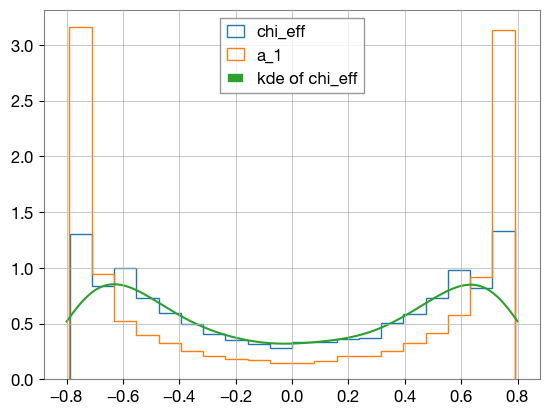

In [180]:
plt.hist(chi_eff, bins=20, density=True, histtype='step', label='chi_eff')
plt.hist(a_1, bins=20, density=True, histtype='step', label='a_1')
a_1_ = np.linspace(-a_max, a_max, 1000)
plt.plot(a_1_, kde(a_1_), label='kde of chi_eff')
plt.legend()
plt.show()

In [188]:
chi_eff_ = np.sort(np.concatenate((kde.resample(size=10)[0], [0.,-0.8,0.8])))

In [266]:
20*100*10*10

200000

In [349]:
size1 = 20
size2 = 100
size3 = 10

mtot_min = snr.mtot_min
detectors = snr.detector_list.copy()
detector_tensor = snr.detector_tensor_list.copy()
num_det = np.arange(len(detectors), dtype=int)
mtot_table = np.sort(
            mtot_min + snr.mtot_max - np.geomspace(mtot_min, snr.mtot_max, size2)
        )

ratio_table = np.geomspace(snr.ratio_min, snr.ratio_max, size1)
# a_1 = np.linspace(0, 1, 10)
# interpolation along mtot for each mass_ratio
a_1_table = np.random.choice(buffer, size3-3, replace=False)
# add 0, -0.8, 0.8 to a_1_table
a_1_table = np.concatenate((a_1_table, [0., -0.8, 0.8]))
a_1_table = np.sort(a_1_table)
a_2_table = np.random.choice(buffer, size3-3, replace=False)
# add 0, -0.8, 0.8 to a_2_table
a_2_table = np.concatenate((a_2_table, [0., -0.8, 0.8]))
a_2_table = np.sort(a_2_table)

mass_1 = np.zeros((size1, size2, size3, size3))
mass_2 = np.zeros((size1, size2, size3, size3))
a_1 = np.zeros((size1, size2, size3, size3))
a_2 = np.zeros((size1, size2, size3, size3))

for i, q in enumerate(ratio_table):
    for j, mtot in enumerate(mtot_table):
        for l, a_1_ in enumerate(a_1_table):
            for m, a_2_ in enumerate(a_2_table):
                mass_1[i, j, l, m] = mtot / (1 + q)
                mass_2[i, j, l, m] = mass_1[i, j, l, m] * q
                a_1[i, j, l, m] = a_1_
                a_2[i, j, l, m] = a_2_

In [350]:
mass_1 = np.array(mass_1)
mass_2 = np.array(mass_2)
a_1 = np.array(a_1)
a_2 = np.array(a_2)
chi_eff = np.array(chi_eff)

In [351]:
print(f"Generating interpolator for {detectors} detectors")

if mtot_min < 1.0:
    raise ValueError("Error: mass too low")

# this geocent_time is only to get partialScaledSNR
geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
luminosity_distance_ = 100.0

# calling bilby_snr
optimal_snr_unscaled_ref = snr.compute_bilby_snr(
    mass_1=mass_1.flatten(),
    mass_2=mass_2.flatten(),
    luminosity_distance=luminosity_distance_,
    theta_jn=theta_jn_,
    psi=psi_,
    phase=phase_,
    geocent_time=geocent_time_,
    ra=ra_,
    dec=dec_,
    a_1=a_1.flatten(),
    a_2=a_2.flatten(),
)

Generating interpolator for ['L1'] detectors


100%|█████████████████████████████████████████████████████| 199600/199600 [00:54<00:00, 3654.00it/s]


In [353]:
# Vectorized computation for effective luminosity distance
Fp = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
        for tensor in detector_tensor
    ]
)
Fc = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
        for tensor in detector_tensor
    ]
)
dl_eff = luminosity_distance_ / np.sqrt(
    Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
    + Fc**2 * np.cos(theta_jn_) ** 2
)

# for partialscaledSNR
Mchirp = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
a2 = Mchirp ** (5.0 / 6.0)
# filling in interpolation table for different detectors
snr_partial_buffer = []
for j in num_det:
    snr_ = np.reshape(optimal_snr_unscaled_ref[detectors[j]], (size1, size2, size3, size3))
    snr_partial_buffer.append(
            (dl_eff[j] / a2) * snr_,
    )
snr_partial_ref = np.array(snr_partial_buffer)[0]
# save array
np.save('snr_partial.npy', snr_partial_ref)

In [354]:
snr_partial_ref.shape

(20, 100, 10, 10)

In [404]:
size = 10
# q = np.random.uniform(snr.ratio_min, snr.ratio_max, size=size)
# mtot = np.random.uniform(snr.mtot_min, snr.mtot_max, size=size)
# mass_1_ = mtot / (1 + q)
# mass_2_ = mass_1_ * q
# a_1_ = np.random.uniform(-a_max, a_max, size=size)
# a_2_ = np.random.uniform(-a_max, a_max, size=size)
mass_1_ = 30* np.ones(size)
mass_2_ = 25* np.ones(size)
a_1_ = np.zeros(size)
a_2_ = np.zeros(size)

# geocent_time cannot be array here
# this geocent_time is only to get partialScaledSNR
geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
luminosity_distance_ = 500.0

# Vectorized computation for effective luminosity distance
Fp = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
        for tensor in detector_tensor
    ]
)
Fc = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
        for tensor in detector_tensor
    ]
)
dl_eff = luminosity_distance_ / np.sqrt(
    Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
    + Fc**2 * np.cos(theta_jn_) ** 2
)

ratio = snr.ratio_arr.copy()
# interpolation along mtot for each mass_ratio

# calling bilby_snr
optimal_snr_unscaled = snr.compute_bilby_snr(
    mass_1=mass_1_,
    mass_2=mass_2_,
    luminosity_distance=luminosity_distance_,
    theta_jn=theta_jn_,
    psi=psi_,
    phase=phase_,
    geocent_time=geocent_time_,
    ra=ra_,
    dec=dec_,
    a_1=a_1_,
    a_2=a_2_,
)
# for partialscaledSNR
Mchirp = ((mass_1_ * mass_2_) ** (3 / 5)) / ((mass_1_ + mass_2_) ** (1 / 5))
a2 = Mchirp ** (5.0 / 6.0)
# filling in interpolation table for different detectors
snr_partial_buffer = []
for j in num_det:
    snr_partial_buffer.append(
            (dl_eff[j] / a2) * optimal_snr_unscaled[detectors[j]],
    )

snr_partial_true = np.array(snr_partial_buffer)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.19it/s]


In [405]:
snr_partial_true[0]

array([2396.92829161, 2396.92829161, 2396.92829161,
       2396.92829161, 2396.92829161, 2396.92829161,
       2396.92829161, 2396.92829161, 2396.92829161,
       2396.92829161])

In [54]:
snr_partial_true.shape, a2.shape, dl_eff.shape, optimal_snr_unscaled['L1'].shape

((3, 1000), (1000,), (3,), (1000,))

In [344]:
chi_eff[0,0,:], chi_eff[2,10,:], chi_eff[4,20,:]

(array([-0.73916162, -0.70115602, -0.67676528, -0.62342882,
        -0.60942547, -0.54855714, -0.50075005, -0.43814484,
        -0.41876969, -0.39619882, -0.25255302, -0.23688141,
        -0.20027294,  0.30846585,  0.36743282,  0.63261998,
         0.63962423,  0.67276791,  0.67601157,  0.76722017]),
 array([-0.73629602, -0.70047112, -0.67749166, -0.617757  ,
        -0.59944434, -0.53896062, -0.50075343, -0.42725569,
        -0.41254018, -0.38636513, -0.25691177, -0.22780889,
        -0.19176332,  0.29939261,  0.37040426,  0.62014172,
         0.62757048,  0.67132708,  0.6747599 ,  0.76733064]),
 array([-0.73320614, -0.69973262, -0.67827488, -0.61164123,
        -0.58868199, -0.52861299, -0.50075708, -0.41551424,
        -0.40582309, -0.37576175, -0.26161168, -0.21802626,
        -0.18258765,  0.2896092 ,  0.37360827,  0.60668678,
         0.61457329,  0.66977348,  0.67341027,  0.76744976]))

In [343]:
(0.4*20+ (-0.2)*10) / (20+10), (0.4*20+ (-0.2)*10) / (20+10)

0.2

In [401]:
def catmull_rom_spline(p, t):
    """1D Catmull-Rom interpolation with 4 points."""
    M = 0.5 * np.array([
        [0,  2,  0,  0],
        [-1, 0,  1,  0],
        [2, -5,  4, -1],
        [-1, 3, -3,  1]
    ])
    T = np.array([1, t, t**2, t**3])
    return T @ M @ p

def find_index_1d(x_array, x_new):
    """Find index i such that x_array[i] <= x_new <= x_array[i+1], with clamping."""
    N = len(x_array)
    if x_new <= x_array[1]:
        return 1
    elif x_new >= x_array[N - 2]:
        return N - 3
    else:
        i = np.searchsorted(x_array, x_new) - 1
        return max(1, min(i, N - 3))

def catmull_rom_4d_interp(q_array, mtot_array, a1_array, a2_array, snr_array, q_new, mtot_new, a1_new, a2_new):
    """Perform 4D Catmull-Rom interpolation."""
    q_idx = find_index_1d(q_array, q_new)
    m_idx = find_index_1d(mtot_array, mtot_new)
    a1_idx = find_index_1d(a1_array, a1_new)
    a2_idx = find_index_1d(a2_array, a2_new)

    # Extract 4-point windows in each dimension
    qs = q_array[q_idx - 1 : q_idx + 3]
    ms = mtot_array[m_idx - 1 : m_idx + 3]
    a1s = a1_array[a1_idx - 1 : a1_idx + 3]
    a2s = a2_array[a2_idx - 1 : a2_idx + 3]
    F = snr_array[q_idx - 1 : q_idx + 3,
                  m_idx - 1 : m_idx + 3,
                  a1_idx - 1 : a1_idx + 3,
                  a2_idx - 1 : a2_idx + 3]  # shape (4,4,4,4)

    # Normalized coordinates
    tq = (q_new - qs[1]) / (qs[2] - qs[1])
    tm = (mtot_new - ms[1]) / (ms[2] - ms[1])
    ta1 = (a1_new - a1s[1]) / (a1s[2] - a1s[1])
    ta2 = (a2_new - a2s[1]) / (a2s[2] - a2s[1])
    tq = np.clip(tq, 0, 1)
    tm = np.clip(tm, 0, 1)
    ta1 = np.clip(ta1, 0, 1)
    ta2 = np.clip(ta2, 0, 1)

    # Tricubic interpolation logic, extended to 4D:
    temp_q = np.zeros(4)
    for i in range(4):
        temp_m = np.zeros(4)
        for j in range(4):
            temp_a1 = np.zeros(4)
            for k in range(4):
                # Interpolate along a2 (last axis)
                temp_a1[k] = catmull_rom_spline(F[i, j, k, :], ta2)
            # Interpolate along a1
            temp_m[j] = catmull_rom_spline(temp_a1, ta1)
        # Interpolate along mtot
        temp_q[i] = catmull_rom_spline(temp_m, tm)
    # Interpolate along q
    snr_new = catmull_rom_spline(temp_q, tq)
    return snr_new

In [387]:
ratio_table.shape, mtot_table.shape, a_1_table.shape, a_2_table.shape, snr_partial_ref.shape

((20,), (100,), (10,), (10,), (20, 100, 10, 10))

In [406]:
i = 0
catmull_rom_2d_interp(
    ratio_table, mtot_table, a_1_table, a_2_table, snr_partial_ref,
    q_new=mass_2_[i] / mass_1_[i],
    mtot_new=mass_1_[i] + mass_2_[i],
    a1_new=a_1_[i],
    a2_new=a_2_[i]
)#* a2[i]/dl_eff[0]    # scale by effective distance and chirp mass

2024.2803213930692

In [407]:
snr_partial_true[0][i]#* a2[i]/dl_eff[0]

2396.928291607153

In [12]:
snr_new

1737.287091585757

In [17]:
def cubic_spline_4pts(x, y, i):

    A = np.zeros((12, 12))
    b = np.zeros(12)

    # Cubic polynomial: a*x^3 + b*x^2 + c*x + d

    # Function values at endpoints
    A[0, 0:4] = [x[0]**3, x[0]**2, x[0], 1]
    A[1, 0:4] = [x[1]**3, x[1]**2, x[1], 1]
    A[2, 4:8] = [x[1]**3, x[1]**2, x[1], 1]
    A[3, 4:8] = [x[2]**3, x[2]**2, x[2], 1]
    A[4, 8:12] = [x[2]**3, x[2]**2, x[2], 1]
    A[5, 8:12] = [x[3]**3, x[3]**2, x[3], 1]

    b[0:6] = [y[0], y[1], y[1], y[2], y[2], y[3]]

    # First derivative continuity at x2 and x3
    A[6, 0:4] = [3*x[1]**2, 2*x[1], 1, 0]
    A[6, 4:8] = [-3*x[1]**2, -2*x[1], -1, 0]

    A[7, 4:8] = [3*x[2]**2, 2*x[2], 1, 0]
    A[7, 8:12] = [-3*x[2]**2, -2*x[2], -1, 0]

    # Second derivative continuity at x2 and x3
    A[8, 0:4] = [6*x[1], 2, 0, 0]
    A[8, 4:8] = [-6*x[1], -2, 0, 0]

    A[9, 4:8] = [6*x[2], 2, 0, 0]
    A[9, 8:12] = [-6*x[2], -2, 0, 0]

    # Natural spline boundary conditions (second derivative zero at endpoints)
    A[10, 0:4] = [6*x[0], 2, 0, 0]
    A[11, 8:12] = [6*x[3], 2, 0, 0]

    # Solve linear system
    coeffs = np.linalg.solve(A, b)

    # Return each interval's coefficients [a_i, b_i, c_i, d_i]
    return coeffs[i*4:(i+1)*4]

def find_index_1d(x_array, x_new):
    """Find index i such that x_array[i] <= x_new <= x_array[i+1], with clamping."""
    N = len(x_array)
    if x_new <= x_array[1]:
        return 1, 0
    elif x_new >= x_array[N - 2]:
        return N - 3, 1
    else:
        i = np.searchsorted(x_array, x_new) - 1
        return max(1, min(i, N - 3)), 2
    
def cubic_function_4pts(x, coeffs):
    """
    Evaluate cubic polynomial defined by 4 points at x.
    coeffs should be of the form [a, b, c, d] for the polynomial a*x^3 + b*x^2 + c*x + d
    """
    return coeffs[0] * x**3 + coeffs[1] * x**2 + coeffs[2] * x + coeffs[3]

q_array=snr.ratio_arr
mtot_array=snr.mtot_arr
snr_array=snr_partial_[:,0,:]
q_new=q[0]
mtot_new=mtot[0]
"""Perform 2D Catmull-Rom interpolation."""
q_idx, int_q = find_index_1d(q_array, q_new)
m_idx, int_m = find_index_1d(mtot_array, mtot_new)

# Select 4x4 grid around (q_new, mtot_new)
qs = q_array[q_idx - 1: q_idx + 3]
ms = mtot_array[m_idx - 1: m_idx + 3]
F = snr_array[q_idx - 1: q_idx + 3, m_idx - 1: m_idx + 3]  # shape (4,4)

# Interpolate along mtot for each q-row
temp = np.zeros(4)
for i in range(4):
    coeff_ = cubic_spline_4pts(ms, F[i, :], int_m)
    temp[i] = cubic_function_4pts(mtot_new, coeff_)

# Interpolate final value along q
coeff = cubic_spline_4pts(qs, temp, int_q)
snr_new = cubic_function_4pts(q_new, coeff)

In [18]:
snr_new

1737.287091585757

In [102]:
import jax.numpy as jnp
from jax import jit, vmap, lax

@jit
def catmull_rom_spline(p, t):
    M = 0.5 * jnp.array([
        [0,  2,  0,  0],
        [-1, 0,  1,  0],
        [2, -5,  4, -1],
        [-1, 3, -3,  1]
    ])
    T = jnp.array([1.0, t, t**2, t**3])
    return T @ M @ p

@jit
def find_index_1d(x_array, x_new):
    N = x_array.shape[0]
    i = jnp.sum(x_array <= x_new) - 1
    return jnp.clip(i, 1, N - 3)

@jit
def catmull_rom_2d_interp_single(q_array, mtot_array, snr_array, q_new, mtot_new):
    q_idx = find_index_1d(q_array, q_new)
    m_idx = find_index_1d(mtot_array, mtot_new)

    # Dynamic slices (for 4x4 neighborhood)
    F = lax.dynamic_slice(snr_array, (q_idx - 1, m_idx - 1), (4, 4))
    qs = lax.dynamic_slice(q_array, (q_idx - 1,), (4,))
    ms = lax.dynamic_slice(mtot_array, (m_idx - 1,), (4,))

    # Relative coordinates
    tq = (q_new - qs[1]) / (qs[2] - qs[1])
    tm = (mtot_new - ms[1]) / (ms[2] - ms[1])
    tq = jnp.clip(tq, 0.0, 1.0)
    tm = jnp.clip(tm, 0.0, 1.0)

    # Interpolate along mtot (columns)
    def interp_m_row(i):
        return catmull_rom_spline(F[i, :], tm)
    
    temp = jnp.stack([interp_m_row(i) for i in range(4)])
    return catmull_rom_spline(temp, tq)

@jit
def batched_catmull_rom_2d(q_array, mtot_array, snr_array, q_new_batch, mtot_new_batch):
    # Vectorize only over q_new and mtot_new
    vmapped_interp = vmap(
        lambda q, m: catmull_rom_2d_interp_single(q_array, mtot_array, snr_array, q, m),
        in_axes=(0, 0)
    )
    return vmapped_interp(q_new_batch, mtot_new_batch)


# q_array = jnp.array(snr.ratio_arr)
# mtot_array = jnp.array(snr.mtot_arr)
# snr_array = jnp.array(snr_partial_[:,0,:])
# q_new = jnp.array(q[0])
# mtot_new = jnp.array(mtot[0])

# snr_new = catmull_rom_2d_interp(q_array, mtot_array, snr_array, q_new, mtot_new)
# print(snr_new)

In [103]:
q_array = jnp.array(snr.ratio_arr)
mtot_array = jnp.array(snr.mtot_arr)
snr_array = jnp.array(snr_partial_[:,0,:])
q_new = jnp.array(q)
mtot_new = jnp.array(mtot)

# Query batch
q_new_batch = jnp.array([0.55, 0.72, 0.90])
mtot_new_batch = jnp.array([2.1, 2.5, 2.8])

# Interpolate
snr_partial_pred1 = batched_catmull_rom_2d(q_array, mtot_array, snr_array, q_new, mtot_new)
snr_pred1 = snr_partial_pred1*(a2 / dl_eff[0])

In [76]:
snr_partial_pred1*(a2 / dl_eff[0]), optimal_snr_unscaled['L1']

(Array([522.85443, 430.64316, 321.00262, ..., 410.02454,
        170.36212, 453.03372], dtype=float32),
 array([522.88940429, 430.64745172, 321.00320745, ...,
        410.02651661, 170.36810368, 453.06071546]))

In [45]:
%timeit snr_batch = batched_catmull_rom_2d(q_array, mtot_array, snr_array, q_new, mtot_new)

235 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
snr_partial_new

array([[2185.73692206, 1454.52121682, 1411.14488771, ...,
        2610.41192525, 2568.81510465, 1987.39630359],
       [2185.73692206, 1454.52121682, 1411.14488771, ...,
        2610.41192525, 2568.81510465, 1987.39630359],
       [1700.6577253 , 1096.48714003, 1051.06353928, ...,
        1966.9310175 , 1928.55972619, 1506.69036275]])

In [99]:
import jax.numpy as jnp
from jax import jit, vmap, lax

@jit
def find_index_1d_jax(x_array, x_new):
    N = x_array.shape[0]
    i = jnp.sum(x_array <= x_new) - 1
    i = jnp.clip(i, 1, N - 3)
    cond_0 = x_new <= x_array[1]
    cond_1 = x_new >= x_array[N - 2]
    interval_type = jnp.where(cond_0, 0, jnp.where(cond_1, 1, 2))
    return i, interval_type

@jit
def cubic_spline_4pts_jax(x, y, i):
    def row(i, coeff_idx):
        return jnp.array([x[i]**3, x[i]**2, x[i], 1.0]) if coeff_idx == 0 else jnp.zeros(4)

    A = jnp.zeros((12, 12))
    b = jnp.zeros(12)

    def set_block(A, row_idx, col_offset, coeffs):
        return A.at[row_idx, col_offset:col_offset+4].set(jnp.array(coeffs))

    # Fill A and b (fully unrolled for JAX compatibility)
    A = set_block(A, 0, 0, [x[0]**3, x[0]**2, x[0], 1])
    A = set_block(A, 1, 0, [x[1]**3, x[1]**2, x[1], 1])
    A = set_block(A, 2, 4, [x[1]**3, x[1]**2, x[1], 1])
    A = set_block(A, 3, 4, [x[2]**3, x[2]**2, x[2], 1])
    A = set_block(A, 4, 8, [x[2]**3, x[2]**2, x[2], 1])
    A = set_block(A, 5, 8, [x[3]**3, x[3]**2, x[3], 1])

    b = b.at[0:6].set(jnp.array([y[0], y[1], y[1], y[2], y[2], y[3]]))

    A = A.at[6, 0:4].set(jnp.array([3*x[1]**2, 2*x[1], 1, 0]))
    A = A.at[6, 4:8].set(jnp.array([-3*x[1]**2, -2*x[1], -1, 0]))
    A = A.at[7, 4:8].set(jnp.array([3*x[2]**2, 2*x[2], 1, 0]))
    A = A.at[7, 8:12].set(jnp.array([-3*x[2]**2, -2*x[2], -1, 0]))

    A = A.at[8, 0:4].set(jnp.array([6*x[1], 2, 0, 0]))
    A = A.at[8, 4:8].set(jnp.array([-6*x[1], -2, 0, 0]))
    A = A.at[9, 4:8].set(jnp.array([6*x[2], 2, 0, 0]))
    A = A.at[9, 8:12].set(jnp.array([-6*x[2], -2, 0, 0]))

    A = A.at[10, 0:4].set(jnp.array([6*x[0], 2, 0, 0]))
    A = A.at[11, 8:12].set(jnp.array([6*x[3], 2, 0, 0]))

    coeffs = jnp.linalg.solve(A, b)
    return coeffs[i*4:(i+1)*4]

@jit
def cubic_function_4pts_jax(x, coeffs):
    return coeffs[0]*x**3 + coeffs[1]*x**2 + coeffs[2]*x + coeffs[3]

@jit
def spline_interp_2d_single(q_array, mtot_array, snr_array, q_new, mtot_new):
    q_idx, int_q = find_index_1d_jax(q_array, q_new)
    m_idx, int_m = find_index_1d_jax(mtot_array, mtot_new)

    F = lax.dynamic_slice(snr_array, (q_idx - 1, m_idx - 1), (4, 4))
    qs = lax.dynamic_slice(q_array, (q_idx - 1,), (4,))
    ms = lax.dynamic_slice(mtot_array, (m_idx - 1,), (4,))

    temp = jnp.zeros(4)
    for i in range(4):
        coeff_ = cubic_spline_4pts_jax(ms, F[i, :], int_m)
        temp = temp.at[i].set(cubic_function_4pts_jax(mtot_new, coeff_))

    coeff_final = cubic_spline_4pts_jax(qs, temp, int_q)
    return cubic_function_4pts_jax(q_new, coeff_final)

# Vectorized version
@jit
def batched_spline_interp(q_array, mtot_array, snr_array, q_batch, mtot_batch):
    vmapped_interp = vmap(lambda q, m: spline_interp_2d_single(q_array, mtot_array, snr_array, q, m), in_axes=(0, 0))
    return vmapped_interp(q_batch, mtot_batch)

In [100]:
q_array = jnp.array(snr.ratio_arr)
mtot_array = jnp.array(snr.mtot_arr)
snr_array = jnp.array(snr_partial_[:,0,:])
q_new = jnp.array(q)
mtot_new = jnp.array(mtot)


# Interpolate
snr_partial_pred2 = batched_catmull_rom_2d(q_array, mtot_array, snr_array, q_new, mtot_new)
snr_pred2 = snr_partial_pred1*(a2 / dl_eff[0])

In [101]:
snr_pred1``, snr_pred2

(Array([522.85443, 430.64316, 321.00262, ..., 410.02454,
        170.36212, 453.03372], dtype=float32),
 Array([522.85443, 430.64316, 321.00262, ..., 410.02454,
        170.36212, 453.03372], dtype=float32))

In [105]:
geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
luminosity_distance_ = 100.0
snr_pred3 = snr.snr(mass_1=mass_1_,
        mass_2=mass_2_,
        luminosity_distance=luminosity_distance_,
        theta_jn=theta_jn_,
        psi=psi_,
        phase=phase_,
        geocent_time=geocent_time_,
        ra=ra_,
        dec=dec_,
    )['L1']

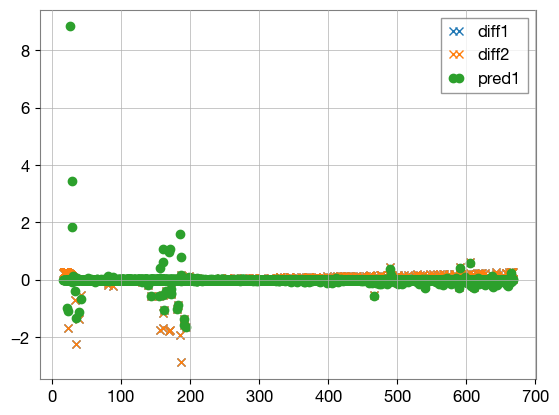

In [108]:
import matplotlib.pyplot as plt
snr_true = optimal_snr_unscaled['L1']
idx = snr_true> 0
plt.plot(snr_true[idx],snr_true[idx]-snr_pred1[idx], label='diff1', marker='x', linestyle='None', color='C0')
plt.plot(snr_true[idx],snr_true[idx]-snr_pred2[idx], label='diff2', marker='x', linestyle='None', color='C1')
plt.plot(snr_true[idx], snr_true[idx]-snr_pred3[idx], label='pred1', marker='o', linestyle='None', color='C2')
plt.legend()
plt.show()

In [44]:
idx_no = abs(snr_true[idx]-snr_batch[idx])>1
snr_true[idx][idx_no], snr_batch[idx][idx_no]

(array([1609.0088373 , 1130.62721984, 2830.24120997,
        2834.30848108, 2816.66420316, 2837.9980039 ,
        2808.26012532, 2838.7975963 , 2834.87381701,
        2831.80851502, 2810.54504652, 1536.15323049,
        2826.0876688 , 1710.51857877, 1145.07116205,
        2830.7712454 , 2787.98064342, 1270.49799518,
        1190.39652363, 2794.13600757, 2824.71821444,
        1317.34811655, 1163.3988352 ]),
 Array([1614.9395, 1132.0879, 2788.6804, 2803.6162, 2796.3408,
        2805.8687, 2806.6282, 2799.209 , 2796.3445, 2806.5635,
        2805.4143, 1550.6266, 2803.1323, 1713.3921, 1162.6875,
        2806.6282, 2928.6113, 1285.6229, 1193.2913, 2783.1853,
        2803.2961, 1323.7009, 1174.3912], dtype=float32))

In [ ]:
def catmull_rom_spline(p, t):
    """1D Catmull-Rom interpolation with 4 points."""
    M = 0.5 * np.array([
        [0,  2,  0,  0],
        [-1, 0,  1,  0],
        [2, -5,  4, -1],
        [-1, 3, -3,  1]
    ])
    T = np.array([1, t, t**2, t**3])
    return T @ M @ p

def find_index_1d(x_array, x_new):
    """Find index i such that x_array[i] <= x_new <= x_array[i+1], with clamping."""
    N = len(x_array)
    if x_new <= x_array[1]:
        return 1
    elif x_new >= x_array[N - 2]:
        return N - 3
    else:
        i = np.searchsorted(x_array, x_new) - 1
        return max(1, min(i, N - 3))

def catmull_rom_4d_interp(q_array, mtot_array, a1_array, a2_array, snr_array, q_new, mtot_new, a1_new, a2_new):
    """Perform 4D Catmull-Rom interpolation."""
    q_idx = find_index_1d(q_array, q_new)
    m_idx = find_index_1d(mtot_array, mtot_new)
    a1_idx = find_index_1d(a1_array, a1_new)
    a2_idx = find_index_1d(a2_array, a2_new)

    # Extract 4-point windows in each dimension
    qs = q_array[q_idx - 1 : q_idx + 3]
    ms = mtot_array[m_idx - 1 : m_idx + 3]
    a1s = a1_array[a1_idx - 1 : a1_idx + 3]
    a2s = a2_array[a2_idx - 1 : a2_idx + 3]
    F = snr_array[q_idx - 1 : q_idx + 3,
                  m_idx - 1 : m_idx + 3,
                  a1_idx - 1 : a1_idx + 3,
                  a2_idx - 1 : a2_idx + 3]  # shape (4,4,4,4)

    # Normalized coordinates
    tq = (q_new - qs[1]) / (qs[2] - qs[1])
    tm = (mtot_new - ms[1]) / (ms[2] - ms[1])
    ta1 = (a1_new - a1s[1]) / (a1s[2] - a1s[1])
    ta2 = (a2_new - a2s[1]) / (a2s[2] - a2s[1])
    # tq = np.clip(tq, 0, 1)
    # tm = np.clip(tm, 0, 1)
    # ta1 = np.clip(ta1, 0, 1)
    # ta2 = np.clip(ta2, 0, 1)

    # Tricubic interpolation logic, extended to 4D:
    temp_q = np.zeros(4)
    for i in range(4):
        temp_m = np.zeros(4)
        for j in range(4):
            temp_a1 = np.zeros(4)
            for k in range(4):
                # Interpolate along a2 (last axis)
                temp_a1[k] = catmull_rom_spline(F[i, j, k, :], ta2)
            # Interpolate along a1
            temp_m[j] = catmull_rom_spline(temp_a1, ta1)
        # Interpolate along mtot
        temp_q[i] = catmull_rom_spline(temp_m, tm)
    # Interpolate along q
    snr_new = catmull_rom_spline(temp_q, tq)
    return snr_new

In [ ]:
i = 0
q_new = mass_2_[i] / mass_1_[i] 
mtot_new = mass_1_[i] + mass_2_[i]
a_1_new = a_1_[i]
a_2_new = a_2_[i] 
catmull_rom_4d_interp(
    ratio_table, mtot_table, a_1_table, a_2_table,
    snr_partial_ref,
    q_new= q_new,
    mtot_new= mtot_new,
    a1_new= a_1_new,
    a2_new= a_2_new,
)#* Mchirp_scaled[i]/dl_eff[0]    # scale by effective distance and chirp mass